In [1]:
import math
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyteomics import fasta, parser
from scipy import stats

In [2]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

In [3]:
data_dir = '../data/external'

In [4]:
def filter_english_words(words, nonexisting_chars='BK', invalid_chars='JXZ',
                         char_repl={'O': 'K', 'U': 'K'}):
    # Remove words with non-existing characters.
    words_new = []
    for word in words:
        word = word.upper()
        invalid_word = False
        if any(char in word for char in nonexisting_chars):
            invalid_word = True
        if not invalid_word:
            # Replace specified characters.
            for char_orig, char_new in char_repl.items():
                word = word.replace(char_orig, char_new)
            words_new.append(word)
    # Remove non-alphabetical characters and invalid amino acids.
    return [''.join(list(filter(
        lambda char: char.isalpha() and char not in invalid_chars, words_new)))]

In [5]:
with open(os.path.join(data_dir, 'cryptonomicon.txt')) as f_in:
    text_cryptonomicon = filter_english_words(
        ''.join(f_in.readlines()).split())
with open(os.path.join(data_dir, '50shades.txt')) as f_in:
    text_50shades = filter_english_words(
        ''.join(f_in.readlines()).split())

In [6]:
proteins_human = [prot.sequence for prot in
                  fasta.read(os.path.join(data_dir, 'nextprot_all_20180117.peff'))]

In [7]:
max_len = 50
missed_cleavages = 1

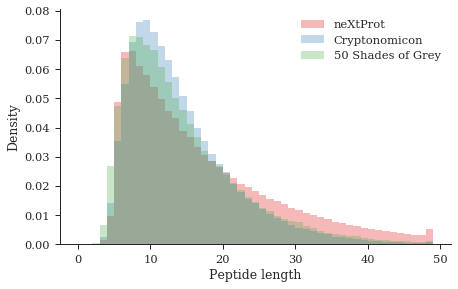

Mode human: 7
Mode Cryptonomicon: 9
Mode 50 Shades of Grey: 7


In [8]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

trypsin_cleavage = '([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))'

peptides_cryptonomicon = parser.cleave(*text_cryptonomicon, trypsin_cleavage, missed_cleavages)
len_cryptonomicon = [len(peptide) for peptide in peptides_cryptonomicon]
peptides_50shades = parser.cleave(*text_50shades, trypsin_cleavage, missed_cleavages)
len_50shades = [len(peptide) for peptide in peptides_50shades]
peptides_human = set().union(
    *[parser.cleave(peptide, trypsin_cleavage, missed_cleavages)
      for peptide in proteins_human])
len_human = [len(peptide) for peptide in peptides_human]

ax.hist(len_human, bins=np.arange(max_len),
        density=True, label='neXtProt', alpha=0.3)
ax.hist(len_cryptonomicon, bins=np.arange(max_len),
        density=True, label='Cryptonomicon', alpha=0.3)
ax.hist(len_50shades, bins=np.arange(max_len),
        density=True, label='50 Shades of Grey', alpha=0.3)

ax.set_xlabel('Peptide length')
ax.set_ylabel('Density')

ax.legend(loc='upper right')

sns.despine()

plt.show()
plt.close()

print(f'Mode human: {stats.mode(len_human, axis=None).mode[0]}')
print(f'Mode Cryptonomicon: {stats.mode(len_cryptonomicon, axis=None).mode[0]}')
print(f'Mode 50 Shades of Grey: {stats.mode(len_50shades, axis=None).mode[0]}')

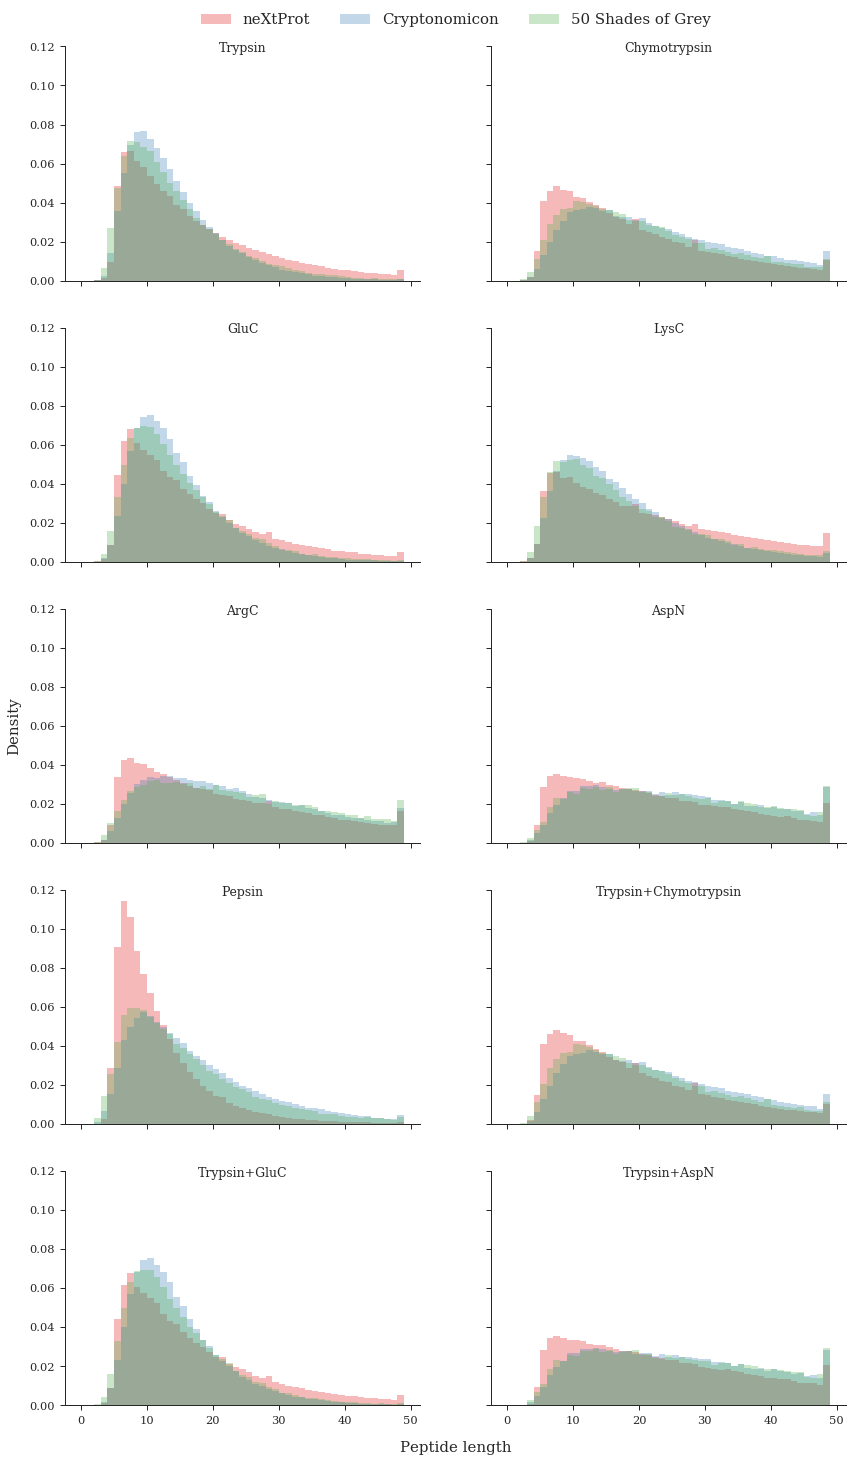

In [9]:
# ExPASy cleavage rules: https://web.expasy.org/peptide_cutter/peptidecutter_enzymes.html
cleavage_rules = [
    ('Trypsin', ['([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))']),
    ('Chymotrypsin', ['([FY](?=[^P]))|(W(?=[^MP]))']),
    ('GluC', ['[DE](?=[^PE])']),    # Not in ExPASy.
    ('LysC', ['K']),
    ('ArgC', ['R']),
    ('AspN', ['\\w(?=D)']),
    ('Pepsin', ['((?<=[^HKR][^P])[^R](?=[FLWY][^P]))|((?<=[^HKR][^P])[FLWY](?=\\w[^P]))']),
    ('Trypsin+Chymotrypsin', ['([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))', '([FY](?=[^P]))|(W(?=[^MP]))']),
    ('Trypsin+GluC', ['([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))', '[DE](?=[^PE])']),
    ('Trypsin+AspN', ['([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))', '\\w(?=D)']),
]

num_columns = 2
num_rows = math.ceil(len(cleavage_rules) / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, True, True,
                         figsize=(num_columns * 7, num_rows * 5))

for ax, (protease, cleavage_rule) in zip(axes.ravel(), cleavage_rules):
    for rule in cleavage_rule:
        peptides_cryptonomicon = parser.cleave(
            *text_cryptonomicon, rule, missed_cleavages)
        peptides_50shades = parser.cleave(
            *text_50shades, rule, missed_cleavages)
        peptides_human = set().union(
            *[parser.cleave(peptide, rule, missed_cleavages)
              for peptide in proteins_human])
        
    len_cryptonomicon = [len(peptide) for peptide in peptides_cryptonomicon]
    len_50shades = [len(peptide) for peptide in peptides_50shades]
    len_human = [len(peptide) for peptide in peptides_human]
    
    ax.hist(len_human, bins=np.arange(max_len),
            density=True, label='neXtProt', alpha=0.3)
    ax.hist(len_cryptonomicon, bins=np.arange(max_len),
            density=True, label='Cryptonomicon', alpha=0.3)
    ax.hist(len_50shades, bins=np.arange(max_len),
            density=True, label='50 Shades of Grey', alpha=0.3)
    
    ax.set_title(protease, y=0.95)
    
    sns.despine(ax=ax)

# Single legend for all subplots.
axes.ravel()[0].legend(loc='upper center', bbox_to_anchor=(1.1, 1.2), ncol=3,
                       fontsize='large')

ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_xlabel('Peptide length', labelpad=15, fontsize='large')
ax.set_ylabel('Density', labelpad=15, fontsize='large')

plt.savefig('pep_len.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()